In [59]:
import pandas as pd
import numpy as np
from collections import deque
import copy
from tqdm import tqdm_notebook as tqdm
import time
import matplotlib.pyplot as plt
%matplotlib inline

# ナップサック問題を作る関数
def generate_problem(N, RAND_MAX):
    value = np.random.randint(1, RAND_MAX, N)
    weight = np.random.randint(1, RAND_MAX, N)
    ratio = value / weight
    capacity = N * RAND_MAX / 6
    return [value, weight, ratio, capacity]

def greedy(problem):
    value = problem[0]
    weight = problem[1]
    ratio = problem[2]
    capacity = problem[3]
    
    ratio_index = np.argsort(ratio)[::-1]
    w = 0
    v = 0
    i = 0
    ans = [0 for i in range(len(value))]
    while i < len(value):
        if w + weight[ratio_index[i]] <= capacity:
            w += weight[ratio_index[i]]
            ans[ratio_index[i]] = 1
            v += value[ratio_index[i]]
            i += 1
        else:
            i += 1
    return [v,ans]

def relaxation(problem, fix):
    value = problem[0]
    weight = problem[1]
    ratio = problem[2]
    capacity = problem[3]
    
    ratio_index = np.argsort(ratio)[::-1]
    w = sum([item[1]*weight[item[0]] for item in fix if item[1]==1])
    v = sum([item[1]*value[item[0]] for item in fix if item[1]==1])
    ans = [0 for i in range(len(value))]
    for item in fix:
        if item[1] == 1:
            ans[item[0]] = 1
    fix_index = [item[0] for item in fix]
    i = 0
    
    while i < len(value):
        if ratio_index[i] not in fix_index:
            if w + weight[ratio_index[i]] <= capacity:
                w += weight[ratio_index[i]]
                ans[ratio_index[i]] = 1
                v += value[ratio_index[i]]
                i += 1
            else:
                ans[ratio_index[i]] = (capacity - w) / weight[ratio_index[i]]
                v += ((capacity - w) / weight[ratio_index[i]]) * value[ratio_index[i]]
                break
        else:
            i += 1
    return [v, ans]

def prued_relax(problem, fix):  
    value = problem[0]
    weight = problem[1]
    ratio = problem[2]
    capacity = problem[3]
    
    fix_index = [item[0] for item in fix]
    # 固定されてない変数を一個取ってくる
    for i in range(len(value)):
        if i not in fix_index:
            stack = deque([[i,0],[i,1]])
            break
   
    ans = deque([])
    # 暫定解
    temp_value = 0
    while stack:
        temp = stack.pop()
        i = temp[0]
        x_i = temp[1]

        ans.append([i, x_i])

        # 許容解がない
        if sum([w[1]*weight[w[0]] for w in fix+list(ans) if w[1]==1]) > capacity:
            while ans:
                flag = ans.pop()
                if flag[1] == 1:
                    break
        else:
            # 線形緩和を解く
            ans_v,ans_w = relaxation(problem, fix+list(ans))
            not_Z_list = [i for i,w in enumerate(ans_w) if (w!=1 and w!=0)]
            # 整数解が見つかった 
            if sum(not_Z_list) == 0:
                # 暫定解より良い解ならば更新する
                if ans_v > temp_value:
                    temp_w = copy.copy(ans_w)
                    temp_value = ans_v
                while ans:
                    flag = ans.pop()
                    if flag[1] == 1:
                        break

            else:
                # 暫定解より大きければ深掘りする
                if ans_v > temp_value:
                    # 分数であるインデックスを取り出す
                    stack.append([not_Z_list[0],0])
                    stack.append([not_Z_list[0],1])
                else:
                    while ans:
                        flag = ans.pop()
                        if flag[1] == 1:
                            break           
    return [temp_value, temp_w]

In [107]:
print("item数:")
N = int(input())
problem = generate_problem(N, 1000)
capacity = problem[3]

problem_df = pd.DataFrame(np.array(problem[:-1]).T, columns=["value","weight","ratio"])
problem_df = problem_df.sort_values(["ratio","weight"], ascending=[False,True]).reset_index(drop=True)

print("capacity:",problem[-1])
print(problem_df)

item数:
10
capacity: 1666.6666666666667
   value  weight     ratio
0  886.0   278.0  3.187050
1  671.0   469.0  1.430704
2  886.0   983.0  0.901322
3  841.0   970.0  0.867010
4  715.0   913.0  0.783133
5  180.0   307.0  0.586319
6  542.0   964.0  0.562241
7  429.0   857.0  0.500583
8  273.0   930.0  0.293548
9  164.0   772.0  0.212435


In [48]:
problem = problem_df.to_numpy().T
problem = list(problem)
problem.append(capacity)

value = problem[0]
weight = problem[1]
ratio = problem[2]

In [55]:
def pegging(problem):
    greedy_v, greedy_ans = greedy(problem)
    relax_v, relax_ans = relaxation(problem, [])
    ans = []
    for i, tf in enumerate(relax_ans):
        
        if tf == 1:
            temp_v, temp_ans = relaxation(problem, ans + [[i, 0]])
            if temp_v < greedy_v:
                ans.append([i, 1])
        
        elif tf == 0:
            temp_v, temp_ans = relaxation(problem, ans + [[i, 1]])
            if temp_v < greedy_v:
                ans.append([i, 0])
    return prued_relax(problem, ans)

In [50]:
#%time enumeration()

In [108]:
%time print(pegging(problem))

[2272, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0]]
CPU times: user 1.32 ms, sys: 286 µs, total: 1.61 ms
Wall time: 1.45 ms


In [52]:
%time prued_relax(problem, [])

CPU times: user 1.95 ms, sys: 324 µs, total: 2.27 ms
Wall time: 2.05 ms


[2457.0, [1, 1, 1, 1, 0, 1, 0, 0, 0, 0]]

釘打ちテストはナップサック問題のrationの種類が多いと単純な分枝限定法より高速になる。
しかし、単純な問題であると単純な分枝限定法の方が高速になる

# RAND_MAX=1000

In [86]:
time_pegging = []
time_prued = []

item = []

n = 100
for N in tqdm(range(1,100000,1000)):
    item.append(N)
    time_prued_sum = []
    time_pegging_sum = []
    
    for i in range(n):
        problem = generate_problem(N, 1000)
        problem = problem_df.to_numpy().T
        problem = list(problem)
        problem.append(capacity)

        value = problem[0]
        weight = problem[1]
        ratio = problem[2]

        start = time.time()
        test1, test2 = prued_relax(problem, [])
        time_prued_sum.append((time.time() - start))

        start = time.time()
        test1, test2 = pegging(problem)
        time_pegging_sum.append((time.time() - start))
    time_prued.append(sum(time_prued_sum)/n)
    time_pegging.append(sum(time_pegging_sum)/n)

In [87]:
time_df = pd.DataFrame({"pegging":time_pegging, 
                        "prued":time_prued},
                       index=item)
time_df

,pegging,prued
1,0.001460,0.001373
1001,0.001700,0.001721
2001,0.001202,0.001244
3001,0.001169,0.001239
4001,0.001225,0.001239
...,...,...
95001,0.001135,0.001199
96001,0.001318,0.001554
97001,0.001412,0.001315
98001,0.001444,0.001528


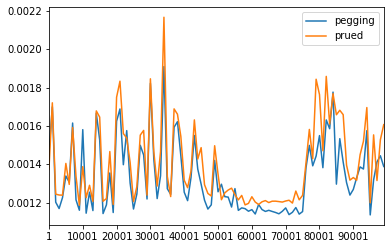

In [90]:
time_df.plot(xticks=range(1,100000,10000))
plt.show()

# RAND_MAX=10

In [92]:
time_pegging = []
time_prued = []

item = []

n = 100
for N in tqdm(range(1,100000,1000)):
    item.append(N)
    time_prued_sum = []
    time_pegging_sum = []
    
    for i in range(n):
        problem = generate_problem(N, 10)
        problem = problem_df.to_numpy().T
        problem = list(problem)
        problem.append(capacity)

        value = problem[0]
        weight = problem[1]
        ratio = problem[2]

        start = time.time()
        test1, test2 = prued_relax(problem, [])
        time_prued_sum.append((time.time() - start))

        start = time.time()
        test1, test2 = pegging(problem)
        time_pegging_sum.append((time.time() - start))
    time_prued.append(sum(time_prued_sum)/n)
    time_pegging.append(sum(time_pegging_sum)/n)

In [94]:
time_df_10 = pd.DataFrame({"pegging":time_pegging, 
                        "prued":time_prued},
                       index=item)
time_df_10

,pegging,prued
1,0.001399,0.001506
1001,0.001059,0.001062
2001,0.001096,0.001124
3001,0.001026,0.001058
4001,0.001067,0.001132
...,...,...
95001,0.001017,0.001171
96001,0.001033,0.001190
97001,0.001029,0.001178
98001,0.000997,0.001136


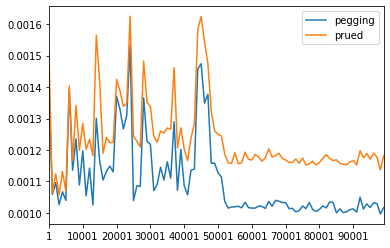

In [95]:
time_df_10.plot(xticks=range(1,100000,10000))
plt.show()

# RAND_MAX=100

In [97]:
time_pegging = []
time_prued = []

item = []

n = 100
for N in tqdm(range(1,100000,1000)):
    item.append(N)
    time_prued_sum = []
    time_pegging_sum = []
    
    for i in range(n):
        problem = generate_problem(N, 100)
        problem = problem_df.to_numpy().T
        problem = list(problem)
        problem.append(capacity)

        value = problem[0]
        weight = problem[1]
        ratio = problem[2]

        start = time.time()
        test1, test2 = prued_relax(problem, [])
        time_prued_sum.append((time.time() - start))

        start = time.time()
        test1, test2 = pegging(problem)
        time_pegging_sum.append((time.time() - start))
    time_prued.append(sum(time_prued_sum)/n)
    time_pegging.append(sum(time_pegging_sum)/n)

In [98]:
time_df_100 = pd.DataFrame({"pegging":time_pegging, 
                        "prued":time_prued},
                       index=item)
time_df_100

,pegging,prued
1,0.001287,0.001243
1001,0.001058,0.001042
2001,0.001110,0.001148
3001,0.001042,0.001066
4001,0.001052,0.001075
...,...,...
95001,0.001025,0.001165
96001,0.001026,0.001174
97001,0.001001,0.001144
98001,0.000992,0.001168


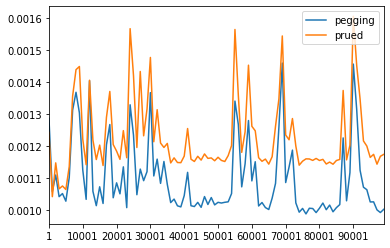

In [99]:
time_df_100.plot(xticks=range(1,100000,10000))
plt.show()

# RAND_MAX=100000

In [101]:
time_pegging = []
time_prued = []

item = []

n = 100
for N in tqdm(range(1,100000,1000)):
    item.append(N)
    time_prued_sum = []
    time_pegging_sum = []
    
    for i in range(n):
        problem = generate_problem(N, 100000)
        problem = problem_df.to_numpy().T
        problem = list(problem)
        problem.append(capacity)

        value = problem[0]
        weight = problem[1]
        ratio = problem[2]

        start = time.time()
        test1, test2 = prued_relax(problem, [])
        time_prued_sum.append((time.time() - start))

        start = time.time()
        test1, test2 = pegging(problem)
        time_pegging_sum.append((time.time() - start))
    time_prued.append(sum(time_prued_sum)/n)
    time_pegging.append(sum(time_pegging_sum)/n)

In [102]:
time_df_100000 = pd.DataFrame({"pegging":time_pegging, 
                        "prued":time_prued},
                       index=item)
time_df_100000

,pegging,prued
1,0.001295,0.001494
1001,0.001047,0.001067
2001,0.001123,0.001129
3001,0.001039,0.001087
4001,0.001026,0.001043
...,...,...
95001,0.001417,0.001628
96001,0.001267,0.001363
97001,0.001191,0.001319
98001,0.001184,0.001295


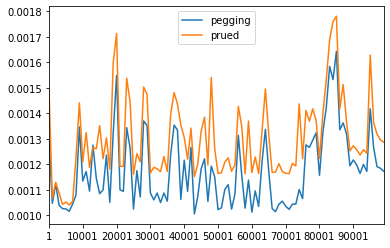

In [104]:
time_df_100000.plot(xticks=range(1,100000,10000))
plt.show()